In [10]:
# enable autoreload
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')
from interface import ImDataParamsBMRR, plot_images, trim_zeros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
infile = "../data/phantom/proc/20240119_145130_202_"
methods = ["withB0Corr", "withoutB0Corr"]

## Postprocessing: Water-fat separation

In [3]:
for method in methods:
    I = ImDataParamsBMRR(infile + "ImDataParamsBMRR_" + method + ".h5")
    I.ImDataParams["signal"] = I.ImDataParams["signal"][:, :, :, 0, :]
    I.set_FatModel("Peanut oil")
    I.set_VARPROparams()
    I.VARPROparams["sampling_stepsize_fm"] = 0.5
    I.run_fieldmapping()
    I.WFIparams["method"] = method
    I.save_WFIparams()

Load ../data/phantom/proc/20240119_145130_202_ImDataParamsBMRR_withB0Corr.h5 ...Done!
Uniform TE spacing: Period = TE(2) - TE(1)
Multi-echo method: multi-res
1/5: Unwrapping... done! (40.94s)
2/5: Mid-res... done! (193.31s)
3/5: High-res... done! (50.09s)
4/5: R2starmap... done! (6.97s)
5/5: Images... done! (0.23s)


/home/jstelter/b0-self-navigation/scripts/../src/interface.py:449: RuntimeWarning: divide by zero encountered in divide
  T2s_ms = 1e3 / inParams['R2s_Hz']


save ../data/phantom/proc/20240119_145130_202_WFIparams_withB0Corr.mat ...done!


## Evaluation: Estimated B0 drift for scan 1

In [29]:
I_method = {}
i = 0
I_method[i] = {} 
for method in methods:
    I_method[i][method] = ImDataParamsBMRR(infile + "ImDataParamsBMRR_" + method + ".h5")
    I_method[i][method].ImDataParams["signal"] = I_method[i][method].ImDataParams["signal"][:,:,:,0,:]
    I_method[i][method].load_WFIparams(infile + "WFIparams_" + method + ".mat")

Load ../data/phantom/proc/20240119_145130_202_ImDataParamsBMRR_withB0Corr.h5 ...Done!
Load ../data/phantom/proc/20240119_145130_202_WFIparams_withB0Corr.mat... 

/home/jstelter/b0-self-navigation/scripts/../src/interface.py:449: RuntimeWarning: divide by zero encountered in divide
  T2s_ms = 1e3 / inParams['R2s_Hz']


Done.
Load ../data/phantom/proc/20240119_145130_202_ImDataParamsBMRR_withoutB0Corr.h5 ...Done!
Load ../data/phantom/proc/20240119_145130_202_WFIparams_withoutB0Corr.mat... Done.


## Plot drift

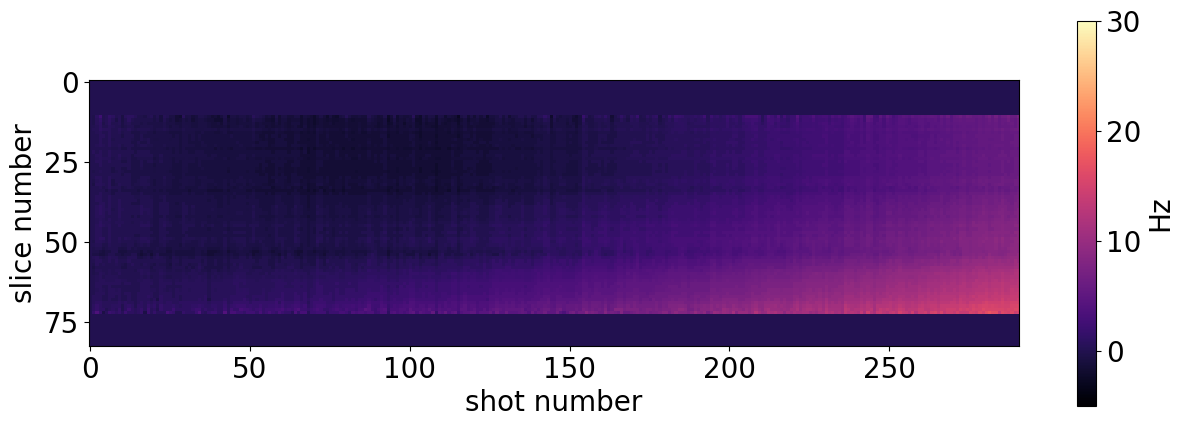

In [30]:
plt.figure(figsize=(15,5))
plt.style.use("default")
matplotlib.rcParams.update({'font.size': 20})
plt.imshow(I_method[0]["withB0Corr"].MotionParams["deltaB0_2d"], cmap="magma", vmin=-5, vmax=30)
plt.xlabel("shot number")
plt.ylabel("slice number")
plt.colorbar(label="Hz")
plt.show()

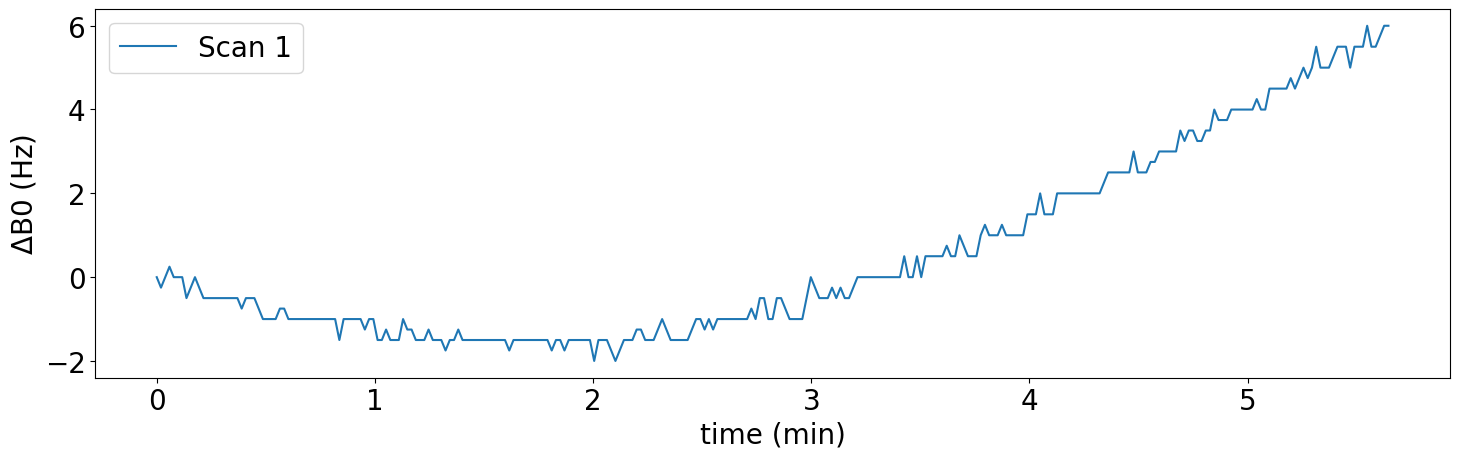

In [31]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 20})
for i in I_method.keys():
    time = np.arange(len(I_method[i]["withB0Corr"].MotionParams["deltaB0"])) * 1167.936 * 1e-3 / 60
    plt.plot(time, I_method[i]["withB0Corr"].MotionParams["deltaB0"][:], color=colors[i], label="Scan " + str(i+1))
plt.legend()
plt.ylabel(r"$\Delta$B0 (Hz)")
plt.xlabel("time (min)")
plt.tight_layout()
plt.show()

In [26]:
i = 0 
method1 = "withB0Corr"
method2 = "withoutB0Corr"
scan_name = ""
voxelSize = I_method[i][method1].ImDataParams["voxelSize_mm"]
slice_num = I_method[i][method1].ImDataParams["signal"].shape[2] // 2
mask = I_method[i][method1].get_tissueMaskFilled(10)
phase1 = np.abs(I_method[i][method1].ImDataParams["signal"][:,:,:,-1])
phase1[~mask] = 0

# field-map
plot_images(trim_zeros(phase1, apply_to=I_method[i][method1].WFIparams["fieldmap_Hz"]), "magma", ["axial"], voxelSize, [slice_num, 0, 0], [-100, 50], fig_name="phantom", filename="fieldmap_"+scan_name+method1, trim=False)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["fieldmap_Hz"]), "magma", ["axial"], voxelSize, [slice_num, 0, 0], [-100, 50], fig_name="phantom", filename="fieldmap_"+scan_name+method2, trim=False)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["fieldmap_Hz"] - I_method[i][method1].WFIparams["fieldmap_Hz"]), "seismic", ["axial"], voxelSize, [slice_num, 0, 0], [-25, 25], fig_name="phantom", filename="fieldmap_diff"+scan_name+method1, trim=False)

plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["fieldmap_Hz"]), "magma", ["axial"], voxelSize, [slice_num, 0, 0], [-100, 50], fig_name="phantom", filename="cmap_fieldmap_"+scan_name+method2, location_cmap="right", trim=False, plot_cmap=True)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method1].WFIparams["fieldmap_Hz"] - I_method[i][method2].WFIparams["fieldmap_Hz"]), "seismic", ["axial"], voxelSize, [slice_num, 0, 0], [-25, 25], fig_name="phantom", filename="cmap_fieldmap_diff"+scan_name+method1, trim=False, plot_cmap=True, location_cmap="right")

# T2s
plot_images(trim_zeros(phase1, apply_to=I_method[i][method1].WFIparams["T2s_ms"]), "plasma", ["axial"], voxelSize, [slice_num, 0, 0], [0, 80], fig_name="phantom", filename="T2s_"+scan_name+method1, trim=False)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["T2s_ms"]), "plasma", ["axial"], voxelSize, [slice_num, 0, 0], [0, 80], fig_name="phantom", filename="T2s_"+scan_name+method2, trim=False)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["T2s_ms"] - I_method[i][method1].WFIparams["T2s_ms"]), "seismic", ["axial"], voxelSize, [slice_num, 0, 0], [-50, 50], fig_name="phantom", filename="T2s_diff"+scan_name+method1, trim=False)

plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["T2s_ms"]), "plasma", ["axial"], voxelSize, [slice_num, 0, 0], [0, 80], fig_name="phantom", filename="cmap_T2s_"+scan_name+method2, trim=False, plot_cmap=True, location_cmap="right")
plot_images(trim_zeros(phase1, apply_to=I_method[i][method1].WFIparams["T2s_ms"] - I_method[i][method2].WFIparams["T2s_ms"]), "seismic", ["axial"], voxelSize, [slice_num, 0, 0], [-50, 50], fig_name="phantom", filename="cmap_T2s_diff"+scan_name+method1, trim=False, plot_cmap=True, location_cmap="right")

# PDFF
plot_images(trim_zeros(phase1, apply_to=I_method[i][method1].WFIparams["fatFraction_percent"]), "inferno", ["axial"], voxelSize, [slice_num, 0, 0], [-5, 100], fig_name="phantom", filename="PDFF_"+scan_name+method1, trim=False)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["fatFraction_percent"]), "inferno", ["axial"], voxelSize, [slice_num, 0, 0], [-5, 100], fig_name="phantom", filename="PDFF_"+scan_name+method2, trim=False)
plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["fatFraction_percent"] - I_method[i][method1].WFIparams["fatFraction_percent"]), "seismic", ["axial"], voxelSize, [slice_num, 0, 0], [-5, 5], fig_name="phantom", filename="PDFF_diff"+scan_name+method1, trim=False)

plot_images(trim_zeros(phase1, apply_to=I_method[i][method2].WFIparams["fatFraction_percent"]), "inferno", ["axial"], voxelSize, [slice_num, 0, 0], [-5, 100], fig_name="phantom", filename="cmap_PDFF_"+scan_name+method2, trim=False, plot_cmap=True, location_cmap="right")
plot_images(trim_zeros(phase1, apply_to=I_method[i][method1].WFIparams["fatFraction_percent"] - I_method[i][method2].WFIparams["fatFraction_percent"]), "seismic", ["axial"], voxelSize, [slice_num, 0, 0], [-5, 5], fig_name="phantom", filename="cmap_PDFF_diff"+scan_name+method1, trim=False, plot_cmap=True, location_cmap="right")

In [27]:
# last echo image, phase
for ind_echo in [0, 5, -1]:
    phase1 = np.angle(I_method[i][method1].ImDataParams["signal"][:,:,:,ind_echo])
    phase2 = np.angle(I_method[i][method2].ImDataParams["signal"][:,:,:,ind_echo])
    phase1[~mask] = 0
    phase2[~mask] = 0
    plot_images(trim_zeros(phase1, apply_to=phase1), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [-np.pi, np.pi], fig_name="phantom", filename="phase_echo_" + str(ind_echo) + "_" +method1, trim=False)
    plot_images(trim_zeros(phase1, apply_to=phase2), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [-np.pi, np.pi], fig_name="phantom", filename="phase_echo_" + str(ind_echo) + "_" +method2, trim=False)
    plot_images(trim_zeros(phase1, apply_to=np.angle(np.exp(1j*(phase1-phase2)))), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [-np.pi, np.pi], fig_name="phantom", filename="phase_echo_" + str(ind_echo) + "_diff")
plot_images(phase2, "gray", ["axial"], voxelSize, [slice_num, 0, 0], [-np.pi, np.pi], fig_name="phantom", filename="cmap_phase_echo_" + str(ind_echo) + "_" +method2, location_cmap="right", plot_cmap=True, trim=False)

In [28]:
# last echo image, mag
max_sig = np.percentile(np.abs(I_method[i][method1].ImDataParams["signal"][:,:,:,:]), 99)
for ind_echo in [0, 5, -1]:
    plot_images(trim_zeros(phase1, apply_to=np.abs(I_method[i][method1].ImDataParams["signal"][:,:,:,ind_echo])), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [0, max_sig], fig_name="phantom", filename="mag_echo_" + str(ind_echo) + "_" +method1)
    plot_images(trim_zeros(phase1, apply_to=np.abs(I_method[i][method2].ImDataParams["signal"][:,:,:,ind_echo])), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [0, max_sig], fig_name="phantom", filename="mag_echo_" + str(ind_echo) + "_" +method2)
    plot_images(trim_zeros(phase1, apply_to=np.abs(I_method[i][method2].ImDataParams["signal"][:,:,:,ind_echo]) - np.abs(I_method[i][method1].ImDataParams["signal"][:,:,:,ind_echo])), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [-max_sig, max_sig], fig_name="phantom", filename="mag_echo_" + str(ind_echo) +"_diff")
plot_images(np.abs(I_method[i][method1].ImDataParams["signal"][:,:,:,ind_echo]), "gray", ["axial"], voxelSize, [slice_num, 0, 0], [0, max_sig], fig_name="phantom", filename="cmap_mag_echo_" + str(ind_echo) + "_" +method2, location_cmap="right", plot_cmap=True, trim=False)